In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt


In [3]:
def f(x):
  return 3*x**2 - 4*x + 5

In [4]:
f(3)

20

In [5]:
dx = np.arange(-5,5,0.25)
print(dx)

[-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75]


[100.      91.6875  83.75    76.1875  69.      62.1875  55.75    49.6875
  44.      38.6875  33.75    29.1875  25.      21.1875  17.75    14.6875
  12.       9.6875   7.75     6.1875   5.       4.1875   3.75     3.6875
   4.       4.6875   5.75     7.1875   9.      11.1875  13.75    16.6875
  20.      23.6875  27.75    32.1875  37.      42.1875  47.75    53.6875]


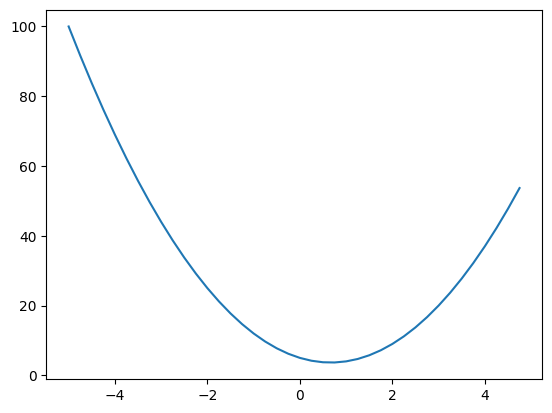

In [6]:
dy = f(dx)
print(dy)
plt.plot(dx,dy)


In [69]:
class Value:
    def __init__(self, number, _nodes=(), _op='', label=''):
        self.number = number
        self.gradient = 0.0
        self._backprop = lambda: None
        self.label = label
        self._op = _op
        self._nodes = set(_nodes)

    def __repr__(self):
        return f"Value(number={self.number})"

    def __rmul__(self,other):
        return self * other


    def __add__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.number + other.number, (self, other), '+', label='+')

        def _backprop():
            self.gradient += out.gradient * 1.0
            other.gradient += out.gradient * 1.0

        out._backprop = _backprop
        return out

    def __radd__(self, other):  # <--- ¡Nuevo método!
      return self + other  # Llama a __add__

    def __mul__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.number * other.number, (self, other), '*', label='*')
        def _backprop():
            self.gradient += out.gradient * other.number
            other.gradient += out.gradient * self.number
        out._backprop = _backprop
        return out

    def tanh(self):
        x = self.number
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), 'tanh', label='tanh')
        def _backprop():
            self.gradient += (1 - t**2) * out.gradient
        out._backprop = _backprop
        return out


    def exp(self):
      x = self.number
      out = Value(math.exp(x),(self,),'exp')

      def _backprop():
        self.gradient += out.gradient * out.number
      out._backprop = _backprop
      return out



    def __pow__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.number ** other.number, (self, other), f'**{other.number}', label='**')
        def _backprop():
            self.gradient += out.gradient * other.number * (self.number ** (other.number - 1))
        out._backprop = _backprop
        return out

    def __neg__(self):
        return self * Value(-1, label='-1')

    def __sub__(self, other):
        return self + (-other)

    def __truediv__(self, other):
        return self * (other ** Value(-1, label='-1'))

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._nodes:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.gradient = 1.0
        for node in reversed(topo):
            node._backprop()

In [8]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._nodes:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{{ %s | data %.4f | grad %.4f }}" % (n.label, n.number, n.gradient), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [9]:
a = Value(2.0, label='a')
b = Value(4.0, label='b')

a/b


Value(number=0.5, op=*, label=*)

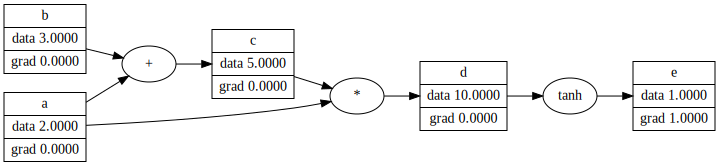

In [10]:
# Crear valores
a = Value(2.0, label='a')
b = Value(3.0, label='b')

# Operaciones
c = a + b
c.label = 'c'
d = c * a
d.label = 'd'
e = d.tanh()
e.label = 'e'

# Backpropagation
e.gradient = 1.0
e.backward()

# Visualizar
draw_dot(e)


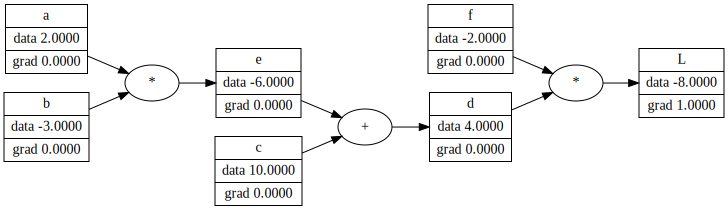

In [11]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L.gradient = 1.0

draw_dot(L)

In [12]:
def lol():

  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.number

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.number += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.number

  print((L2 - L1)/h)

lol()


-3.9999999999995595


In [13]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

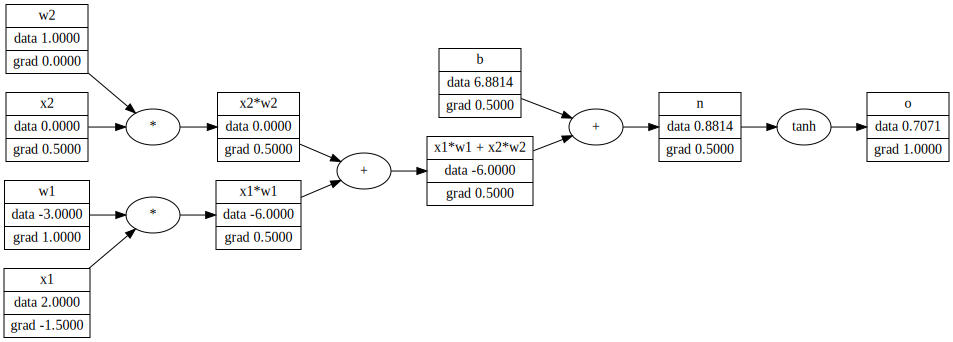

In [14]:
draw_dot(o)

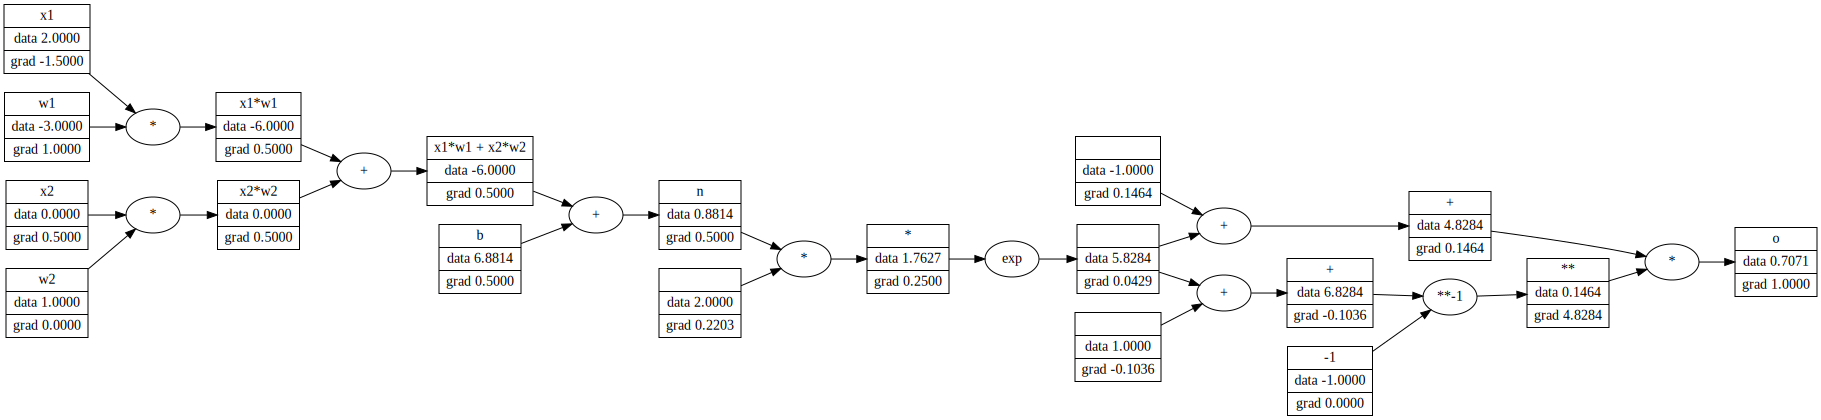

In [15]:

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [16]:
#Example of Pythorch
import torch
import random

In [66]:
#implementar Neuronas y Layers

class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  #wx + b
  def __call__(self, x):
    result = sum((wi*xi for xi,wi in zip(self.w,x)),self.b)
    out = result.tanh()
    return out

  def parametros(self):
    return self.w + [self.b]

class Layer:
  def __init__(self,nin,nop):
    self.neurons = [Neuron(nin) for _ in range(nop)]

  def __call__(self,x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parametros(self):
    return [p for neuron in self.neurons for p in neuron.parametros()]


class MLP:
  def __init__(self,nin,nop):
    size = [nin] + nop
    self.layers = [Layer(size[i],size[i+1]) for i in range(len(nop))]

  def __call__(self,x):
    for value_layer in self.layers:
      x = value_layer(x)
    return x


  def parametros(self):
    return [p for layer in self.layers for p in layer.parametros()]



In [53]:

x = [3.0,6.0]
n = MLP(2,[3,1])
n(x)



#  outputs de los pesos y sesgos de todas las neuronas, y numero total.
for p in n.parametros():
    print(p)
print(len(n.parametros()))



Value(number=-0.3250406620078854, op=, label=)
Value(number=0.6884694006826, op=, label=)
Value(number=0.5958562698847196, op=, label=)
Value(number=-0.3960282549044263, op=, label=)
Value(number=0.29617777795416766, op=, label=)
Value(number=-0.3249936185742506, op=, label=)
Value(number=-0.13584422004441787, op=, label=)
Value(number=0.5491929517115373, op=, label=)
Value(number=0.5194576543103222, op=, label=)
Value(number=-0.9026999595149734, op=, label=)
Value(number=0.891576282547732, op=, label=)
Value(number=0.6329654541256704, op=, label=)
Value(number=-0.6077985298949005, op=, label=)
13


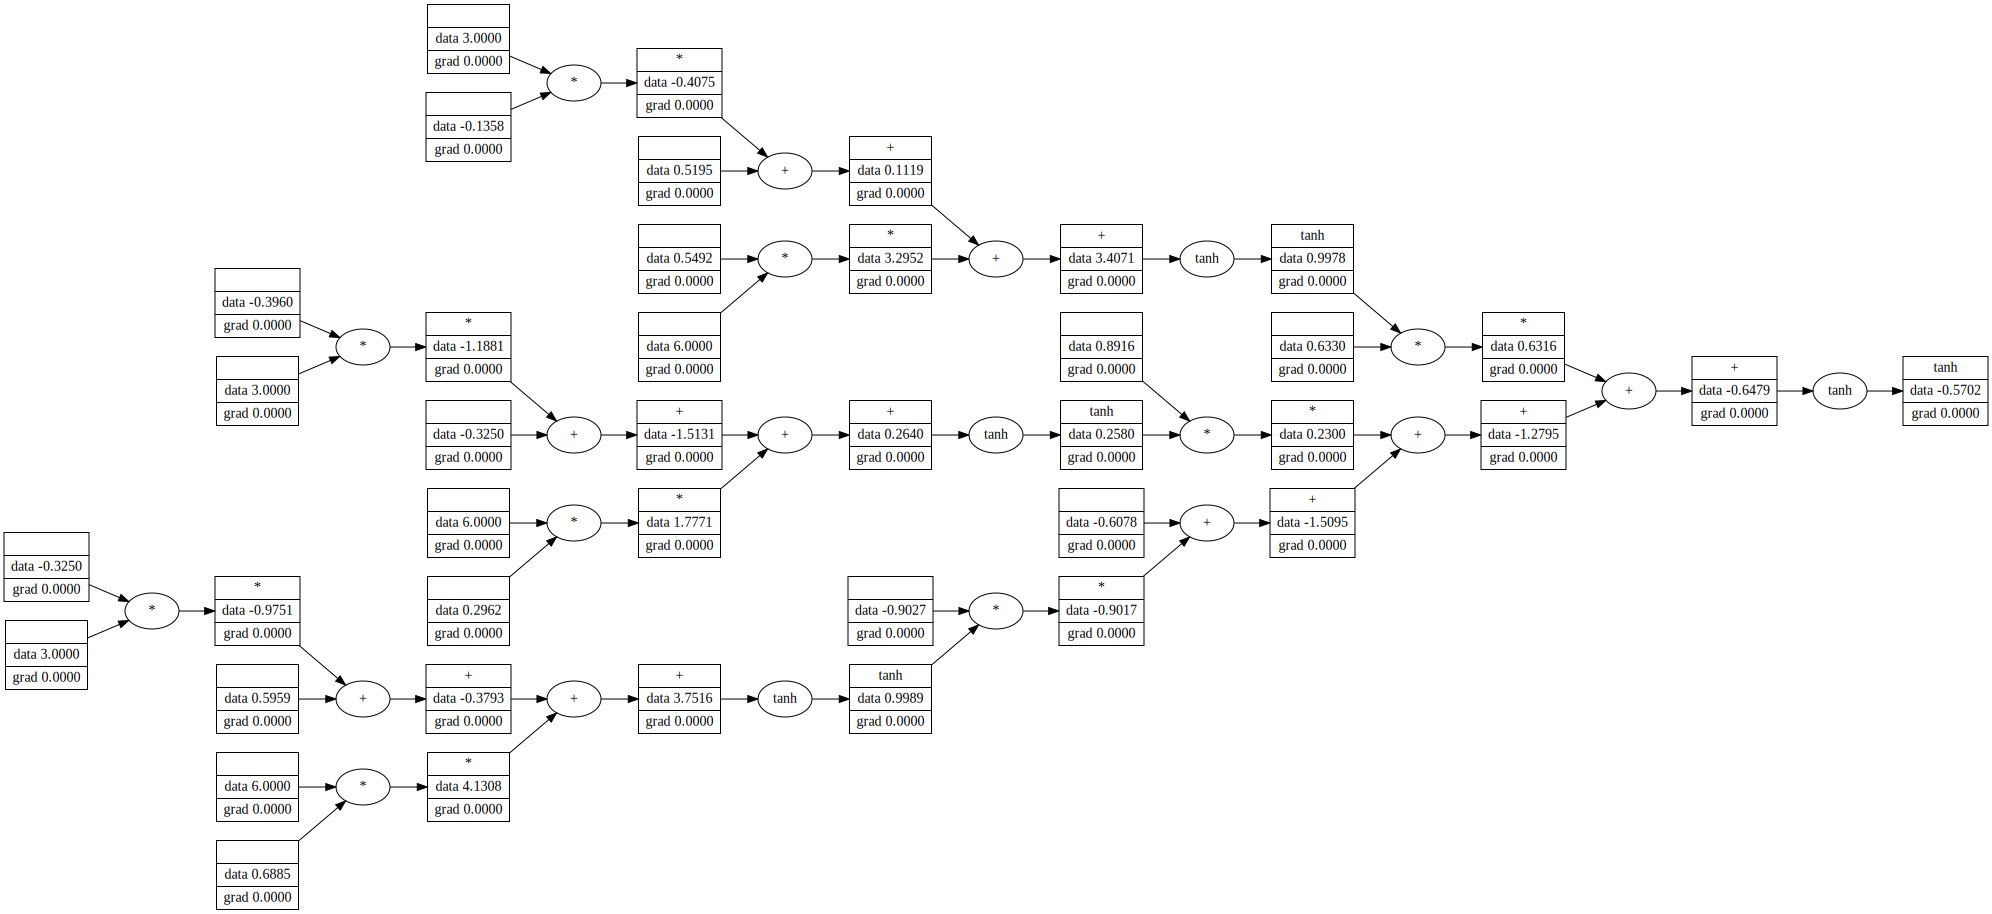

In [54]:
draw_dot(n(x))

In [75]:
n = MLP(3, [4, 4, 1])
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # outputs

In [113]:
ypred = [n(x) for x in xs]

loss = sum((ypredi- ysi)**2 for ypredi,ysi in  zip(ypred,ys))

loss


Value(number=0.1145203170488247)

In [111]:

loss.backward()

In [100]:
n.layers[0].neurons[0].w[0].number


-0.9011931860437827

In [112]:
for p in n.parametros():
  p.number += -0.05 * p.gradient


In [106]:
n.layers[0].neurons[0].w[0].number

-1.2720272500230156

In [114]:
ypred

[Value(number=0.7694100518054922),
 Value(number=-0.9634552657041419),
 Value(number=-0.9793189869029862),
 Value(number=0.755898851020719)]

In [118]:

for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parametros():
    p.gradient = 0.0
  loss.backward()

  # update
  for p in n.parametros():
    p.number += -0.05 * p.gradient

  print(k, loss.number)


0 0.011750967177038111
1 0.01156596660309778
2 0.011387951396388471
3 0.011216502803082288
4 0.011051235302760566
5 0.010891793384820861
6 0.010737848691511613
7 0.0105890974799738
8 0.010445258362599998
9 0.010306070290837997
10 0.010171290752464542
11 0.010040694156493193
12 0.00991407038338736
13 0.009791223481229981
14 0.009671970491043583
15 0.009556140386624237
16 0.009443573116116809
17 0.009334118734156707
18 0.009227636614782517
19 0.009123994736512996
